# Исследовательский анализ и проверка гипотез для сервиса аренды самокатов GoFast

Анализ данных о некоторых пользователях популярного сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках, и проверка гипотез.

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.stats import binom, norm
from scipy import stats as st

In [2]:
# Импорт и общие сведения о датасете пользователей
data1 = pd.read_csv('/datasets/users_go.csv')
display(data1.head())
display(data1.info())



,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

In [3]:
# Импорт и общие сведения о датасете поездок
data2 = pd.read_csv('/datasets/rides_go.csv')
display(data2.head())
display(data2.info())


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

In [4]:
# Импорт и общие сведения о датасете подписок
data3 = pd.read_csv('/datasets/subscriptions_go.csv')
display(data3.head())
display(data3.info())



,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Три датасета импортировано: Пользователи, Поездки, Подписки. 

Датасет Пользователи содержит 1565 записей о пользователях: user_id, имя, возраст, город, тип подписки. 

Датасет Поездки содержит 18068 записей о поездках: user_id, дистанция, длительность, дата.  

Датасет Подписки содержит 2 записи о двух типах подписок (free, ultra): стоимость минуты, стоимость начала поездки, стоимость подписки. 

Пропусков не обнаружено. 

## Предобработка данных

In [5]:
# Создание столбца с датой поездки и создание столбца с порядковым номером месяца
data2['date'] = pd.to_datetime(data2['date'])
display(data2.dtypes)
data2['month'] = data2['date'].dt.month
display(data2.head())


user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [6]:
# Поиск и устранение явных дубликатов в датасете о пользователях
display(data1[data1.duplicated()])
data1 = data1.drop_duplicates()

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [7]:
# Поиск и устранение явных дубликатов в датасете о поездках
display(data2[data2.duplicated()])

,user_id,distance,duration,date,month


Каждой поездке добавлен порядковый номер месяц, извлеченный из даты поездки. 

Явные дубликаты пользователей удалены.

Пропусков не обнаружено. 

## Исследовательский анализ данных

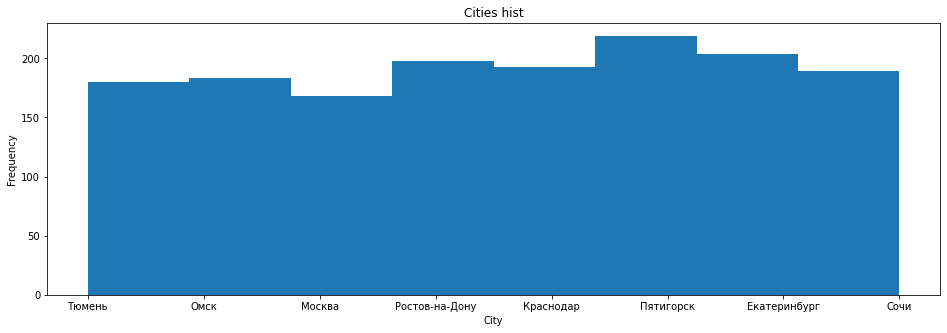

,count
city,
Екатеринбург,204
Краснодар,193
Москва,168
Омск,183
Пятигорск,219
Ростов-на-Дону,198
Сочи,189
Тюмень,180


count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

In [8]:
# Общая информация о городах пользователей
plt.figure(figsize=(16, 5))
plt.hist(data1['city'], align='mid', bins = len(data1['city'].unique()))
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('Cities hist')
plt.show()

pivot = pd.pivot_table(data1, values = 'user_id', index = 'city', aggfunc = 'count')
pivot.columns = ['count']
display(pivot)


data1['city'].describe()

1534 пользователя расположены равномерно в 8 городах. Наибольшее число пользователей в Пятигорске - 219 пользователей. 

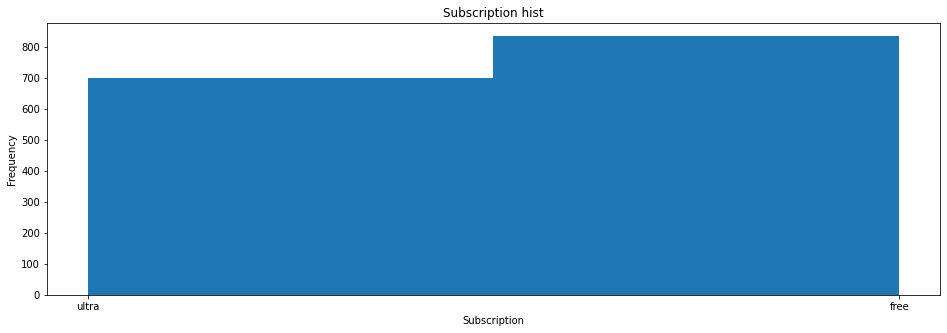

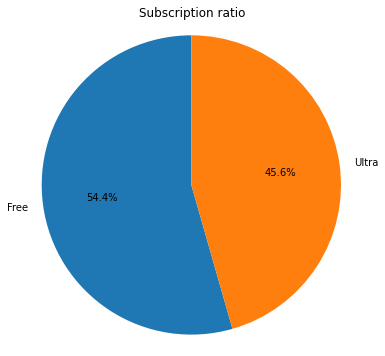

count     1534
unique       2
top       free
freq       835
Name: subscription_type, dtype: object

Процент пользователей с платной подпиской: 45.56714471968709


In [9]:
# Общая информация о подписках пользователей
plt.figure(figsize=(16, 5))
plt.hist(data1['subscription_type'], align='mid', bins = len(data1['subscription_type'].unique()))
plt.xlabel('Subscription')
plt.ylabel('Frequency')
plt.title('Subscription hist')
plt.show()

plt.figure(figsize=(6, 6))  # Set the figure size (optional)
plt.pie(round(data1['subscription_type'].value_counts()/len(data1['subscription_type'])*100, 2), labels=['Free', 'Ultra'], autopct='%1.1f%%', startangle=90)
plt.title('Subscription ratio')
plt.axis('equal')  
plt.show()

display(data1['subscription_type'].describe())

print('Процент пользователей с платной подпиской:', data1[data1['subscription_type'] == 'ultra']['user_id'].count() / len(data1) * 100)


Из 1534 пользователей чуть меньше половины (45.56%) владеют платной подпиской. 

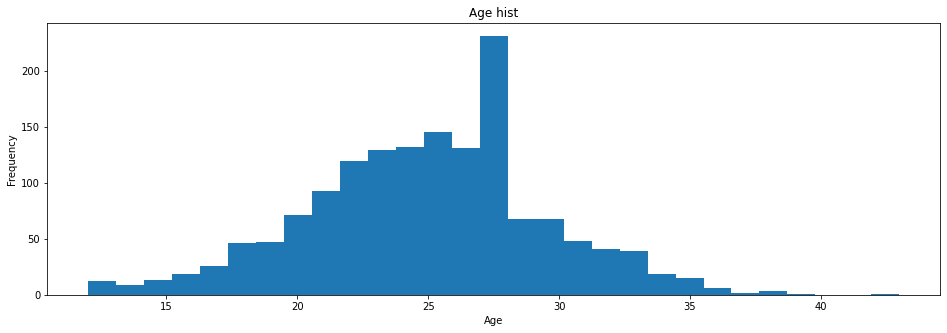

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [10]:
# Общая информация о возрасте пользователей
plt.figure(figsize=(16, 5))
plt.hist(data1['age'], align='mid', bins = len(data1['age'].unique()))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age hist')
plt.show()

data1['age'].describe()


Существуют пользователи от 12 до 43 лет. 

Средний и медианный возраст около 25 лет. 

Большинство пользователей (75%) не старше 28 лет. 

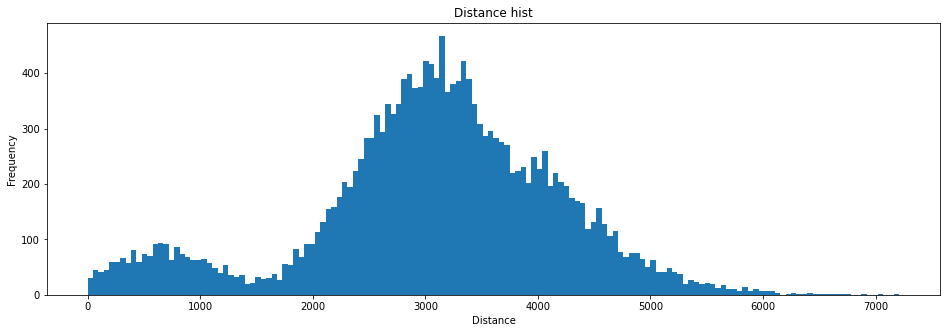

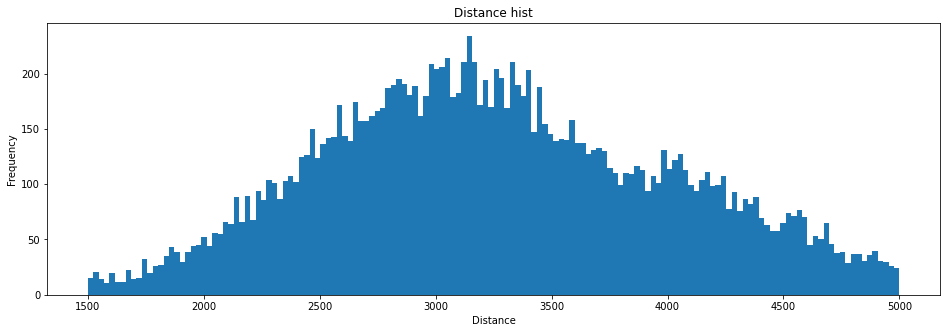

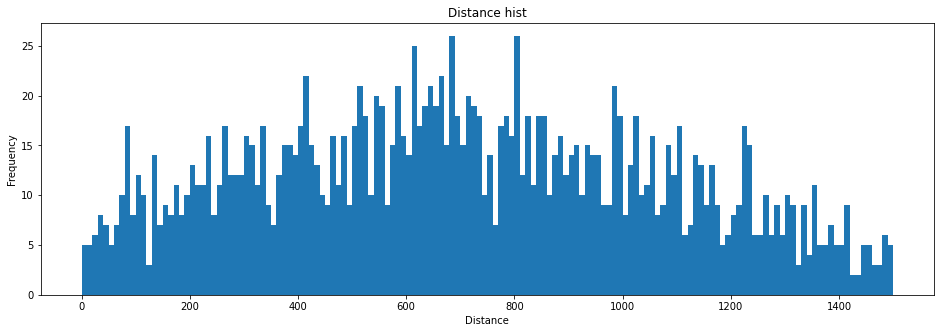

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [11]:
# Общая информация о дистанциях поездок
plt.figure(figsize=(16, 5))
plt.hist(data2['distance'], align='mid', bins = 150)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance hist')
plt.show()

plt.figure(figsize=(16, 5))
plt.hist(data2['distance'], align='mid', bins = 150, range = (1500, 5000))
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance hist')
plt.show()

plt.figure(figsize=(16, 5))
plt.hist(data2['distance'], align='mid', bins = 150, range = (0, 1500))
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance hist')
plt.show()

data2['distance'].describe()



Совершаются поездки от 0.85 метров до 7211 метров. 

Среднее и медианное значение около 3071 и 3133 метров соответственно. Распределение двухмодальное - наиболее частые поездки около 3100 метров, также часто совершают поездки около 700 метров.  

Большинство поездок (75%) не более 3776 метров. 

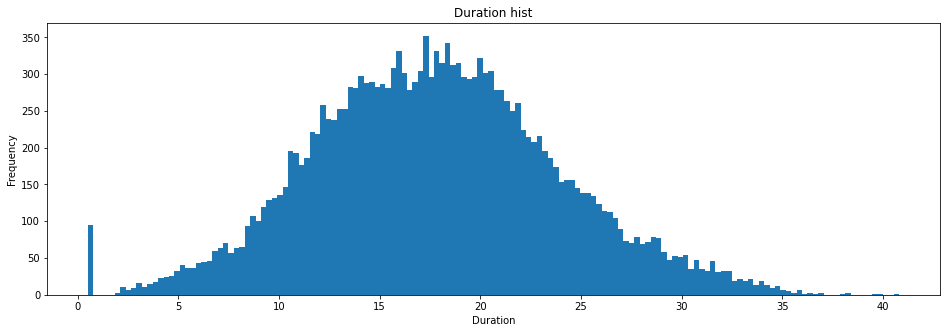

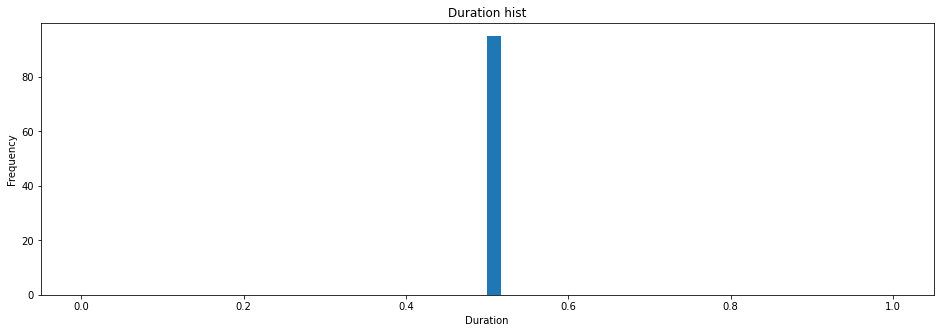

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [12]:
# Общая информация о длительности поездок
plt.figure(figsize=(16, 5))
plt.hist(data2['duration'], align='mid', bins = 150)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Duration hist')
plt.show()

plt.figure(figsize=(16, 5))
plt.hist(data2['duration'], align='mid', bins = 60, range = (0, 1))
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Duration hist')
plt.show()

data2['duration'].describe()

Совершаются поездки от 0.5 до 41 минуты.

Среднее и медианное значение около 18 минут. Также присутствуют частые поездки по 0.5 минуты - вероятнее всего, это округление очень коротких поездок.   

Большинство поездок (75%) не дольше 22 минут.

### Резюме исследовательского анализа данных

1534 пользователя расположены равномерно в 8 городах. Наибольшее число пользователей в Пятигорске - 219 пользователей.

Чуть меньше половины пользователей (45.56%) владеют платной подпиской.

Существуют пользователи от 12 до 43 лет. Средний и медианный возраст около 25 лет. Большинство пользователей (75%) не старше 28 лет.

Совершаются поездки от 0.85 метров до 7211 метров.
Среднее и медианное значение около 3071 и 3133 метров соответственно. Распределение двухмодальное - наиболее частые поездки около 3100 метров, также часто совершают поездки около 700 метров. Большинство поездок (75%) не более 3776 метров.


Совершаются поездки от 0.5 до 41 минуты. Среднее и медианное значение около 18 минут. Также присутствуют частые поездки по 0.5 минуты - вероятнее всего, это округление очень коротких поездок. Большинство поездок (75%) не дольше 22 минут.


## Объединение данных

In [13]:
# Объединение данных о пользователях и поездках
data = pd.merge(data1, data2, on = 'user_id')
display(data.head())
display(data.info())

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


None

In [14]:
# Добавление данных о подписках
data = pd.merge(data, data3, on = 'subscription_type')
display(data.head())
display(data.info())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


None

In [15]:
# Датафрейм о поездках пользователей с подпиской
data_ultra = data.query('subscription_type == "ultra"')
display(data_ultra.head())
display(data_ultra.info())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


None

In [16]:
# Датафрейм о поездках пользователей без подписки
data_free = data.query('subscription_type == "free"')
display(data_free.head())
display(data_free.info())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


None

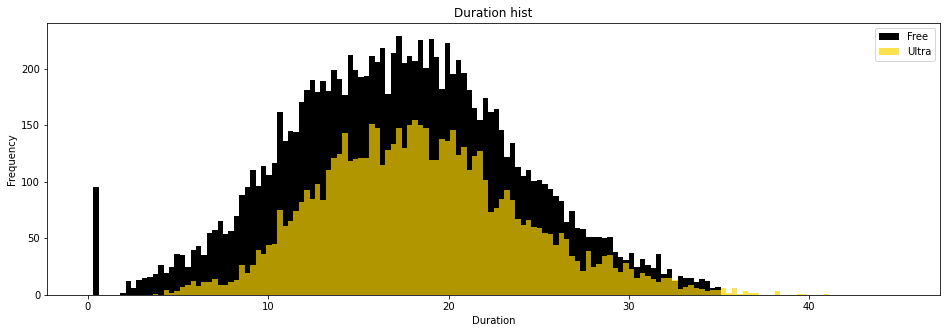

Общие данные о поездках пользователей с подпиской


count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Общие данные о поездках пользователей без подписки


count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [17]:
# Сравнение длительностей поездок пользователей с подпиской и без

plt.figure(figsize=(16, 5))
plt.hist(data_free['duration'], align='mid', bins = 150, range = (0,45), label='Free', color='black')
plt.hist(data_ultra['duration'], align='mid', bins = 150, range = (0,45), label='Ultra', color='gold', alpha = 0.7)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Duration hist')
plt.legend(loc='upper right')
plt.show()

print('Общие данные о поездках пользователей с подпиской')
display(data_ultra['duration'].describe())

print('Общие данные о поездках пользователей без подписки')
display(data_free['duration'].describe())

Пользователями с подпиской совершаются поездки от 4 до 41 минуты, всего 6500 поездок. 

Среднее и медианное значение около 18 минут. 

Большинство поездок от 14.5 до 22 минут. 



Пользователями без подписки совершаются поездки от 0.5 до 35 минут, всего 11568 поездок. 

Среднее и медианное значение около 17 минут. Также присутствуют частые поездки по 0.5 минуты - вероятнее всего, это округление очень коротких поездок.   

Большинство поездок от 13 до 22 минут. 

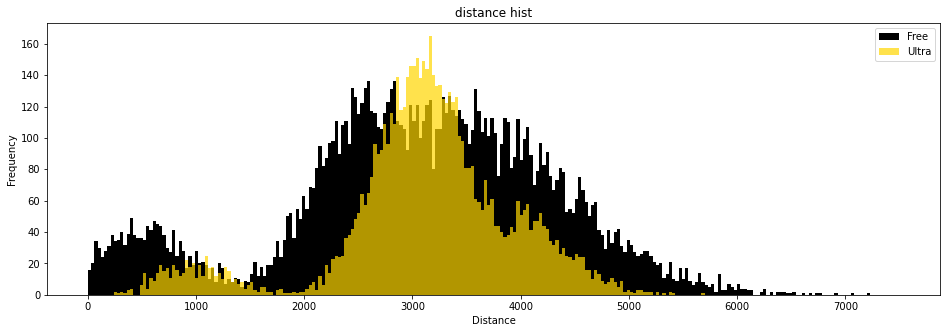

Общие данные о длительности поездок пользователей с подпиской


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Общие данные о длительности поездок пользователей без подписки


count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [18]:
# Сравнение расстояний поездок пользователей с подпиской и без
plt.figure(figsize=(16, 5))
plt.hist(data_free['distance'], align='mid', bins = 250, range = (0,7500), label='Free', color='black')
plt.hist(data_ultra['distance'], align='mid', bins = 250, range = (0,7500), label='Ultra', color='gold', alpha = 0.7)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('distance hist')
plt.legend(loc='upper right')
plt.show()

print('Общие данные о длительности поездок пользователей с подпиской')
display(data_ultra['distance'].describe())

print('Общие данные о длительности поездок пользователей без подписки')
display(data_free['distance'].describe())

Пользователями с подпиской совершаются поездки от 244 до 5700 метров, всего 6500 поездок. 

Среднее и медианное значение около 3120 метров. Также присутствует группа более коротких частых поездок длительностью около 1000 метров.

Большинство поездок от 2785 до 3561 метров. 



Пользователями без подписки совершаются поездки от 0.85 до 7211 метров, всего 11568 поездок. 

Среднее и медианное значение около 3075 метров. Также присутствует группа более коротких частых поездок длительностью около 500 метров.

Большинство поездок от 2366 до 3906 метров. 



## Подсчёт выручки

Создание датафрейма с агрегированными данными о поездках с информацией о суммарном расстоянии, количестве поездок и суммарном время для каждого пользователя за каждый месяц. Добавлена информация о ежемесячных тратах на сервис каждого пользователя.

In [19]:
data['duration'] = np.ceil(data['duration'])
data_user = pd.pivot_table(data, index = ['user_id', 'month'], values=['distance', 'duration'], aggfunc={'distance' : ['sum', 'count'], 'duration': 'sum'})
data_user.columns = ['rides_count', 'distance_sum', 'duration_sum']

for i in data_user.index.levels[0]:
    if i in data_ultra['user_id'].unique():
        data_user.loc[(i, 1):(i, 12), 'subscription'] = 'ultra'
        data_user.loc[(i, 1):(i, 12), 'month_income'] = 0 * data_user.loc[(i, 1):(i, 12), 'rides_count'] + 6 * np.ceil(data_user.loc[(i, 1):(i, 12), 'duration_sum']) + 199
    else:
        data_user.loc[(i, 1):(i, 12), 'subscription'] = 'free'
        data_user.loc[(i, 1):(i, 12), 'month_income'] = 50 * data_user.loc[(i, 1):(i, 12), 'rides_count'] + 8 * np.ceil(data_user.loc[(i, 1):(i, 12), 'duration_sum']) + 0

data_user.head(10)

rides_count  distance_sum  duration_sum subscription  \
user_id month                                                         
1       1                2   7027.511294          42.0        ultra   
        4                1    754.159807           7.0        ultra   
        8                2   6723.470560          46.0        ultra   
        10               2   5809.911100          32.0        ultra   
        11               3   7003.499363          56.0        ultra   
        12               2   6751.629942          28.0        ultra   
2       3                3  10187.723006          63.0        ultra   
        4                2   6164.381824          40.0        ultra   
        6                1   3255.338202          14.0        ultra   
        7                2   6780.722964          48.0        ultra   

               month_income  
user_id month                
1       1             451.0  
        4             241.0  
        8             475.0  
        10            391.0  
        11            535.0  
        12            367.0  
2       3             577.0  
        4             439.0  
        6             283.0  
        7             487.0

## Проверка гипотез

Проверяем нулевую гипотезу, равно ли время поездок пользователей с подпиской времемни поездок пользователей без подписки. Альтернативная гипотеза - пользователи с подпиской тратят больше времени на поездки.

In [20]:
alpha = 0.05 # типовой уровень статистической значимости, если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()

print('Медианное время поездок пользователей с подпиской:', data_ultra['duration'].median())
print('Медианное время поездок пользователей без подписки:', data_free['duration'].median())

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу

Медианное время поездок пользователей с подпиской: 18.17815320055055
Медианное время поездок пользователей без подписки: 17.326890226082043


Нулевая гипотеза, которая предполагала отсутствие различий между группами пользователей, была отвергнута при выбранном уровне значимости alpha=0.05. Это говорит о том, что существуют статистически значимые различия между группами. Практически это означает, что вероятнее всего пользователи с подпиской тратят больше времени на поездки.

Проверяем нулевую гипотезу, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно оптимальному с точки зрения надежности самоката значению 3130 метров. Альтернативная гипотеза - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку превышает оптимальное расстояние (3130 метров). 

In [21]:
target_value = 3130
alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_1samp(data_ultra['distance'], target_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()

print('Средняя дистанция поездок пользователей с подпиской:', data_ultra['distance'].mean())

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу

Средняя дистанция поездок пользователей с подпиской: 3115.4453880370247


Нулевая гипотеза, которая предполагала отсутствие различий между оптимальным значение 3130 метров и средним расстоянием поездки пользователей с подпиской, не была отвергнута при выбранном уровне значимости alpha=0.05. Это говорит о том, что статистически значимых отличий между опитимальным значением и средним значением выборки не обнаружено. Практически это может означать, что в данной выборке нет достаточных доказательств, чтобы утверждать, что пользователи с подпиской в среднем проезжают расстояние, приводящее к повышенному износу самоката. 

Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна выручка от пользователей без подписки. 

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки. 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу

Медианная помесячная выручка пользователей с подпиской: 337.0
Медианная помесячная выручка пользователей без подписки: 274.0


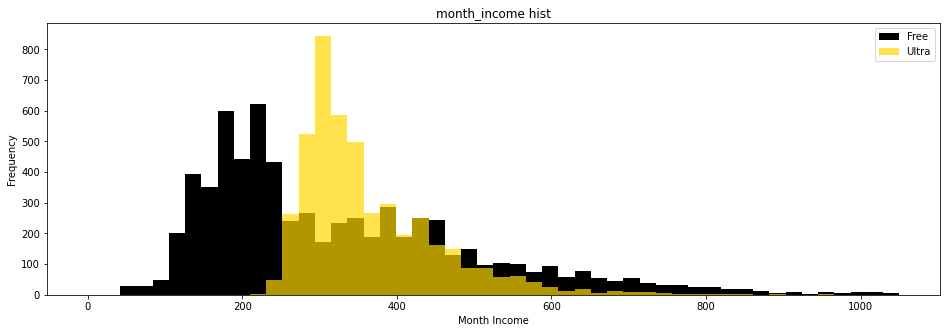

In [22]:
alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_user[data_user['subscription'] == 'ultra']['month_income'], data_user[data_user['subscription'] == 'free']['month_income'], alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()

print('Медианная помесячная выручка пользователей с подпиской:', data_user[data_user['subscription'] == 'ultra']['month_income'].median())
print('Медианная помесячная выручка пользователей без подписки:', data_user[data_user['subscription'] == 'free']['month_income'].median())

plt.figure(figsize=(16, 5))
plt.hist(data_user[data_user['subscription'] == 'free']['month_income'], align='mid', bins = 50, range = (0,1050), label='Free', color='black')
plt.hist(data_user[data_user['subscription'] == 'ultra']['month_income'], align='mid', bins = 50, range = (0,1050), label='Ultra', color='gold', alpha = 0.7)
plt.xlabel('Month Income')
plt.ylabel('Frequency')
plt.title('month_income hist')
plt.legend(loc='upper right')
plt.show()

Нулевая гипотеза, которая предполагала отсутствие различий между помесячными доходами сервиса от пользователей с подпиской и без подписки, была отвергнута при выбранном уровне значимости alpha=0.05. Это говорит о том, что существуют статистически значимые различия между группами. Практически это означает, что вероятнее всего пользователи с подпиской приносят больше выручки сервису, чем пользователи без подписки.

Если техническая команда сервиса обновит сервера, с которыми взаимодействует мобильное приложение и хочет проверить, что из-за этого количество обращений в техподдержку снизится, ей необходимо проверить гипотезу о равенстве средних для зависимых (парных) выборок при помощи метода scipy.stats.ttest_rel(). 

## Выводы

Изучены и обработаны 3 датасета: Пользователи, Поездки, Подписки. 

Исследованы основные параметры пользователей и их поездок в зависимости от наличия подписки: длительность поездки, дальность поездки, месячные траты на сервис.

Рассмотрено 3 гипотезы о пользователях и поездках.

Гипотеза №1: тратят ли пользователи с подпиской больше времени на поездки? Вероятнее всего пользователи с подпиской тратят больше времени на поездки.

Гипотеза №2: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное с точки зрения надежности самоката значение 3130 метров. Нулевая гипотеза, которая предполагала отсутствие различий между оптимальным значение 3130 метров и средним расстоянием поездки пользователей с подпиской, не была отвергнута. Это говорит о том, что статистически значимых отличий между опитимальным значением и средним значением выборки не обнаружено. Практически это может означать, что в данной выборке нет достаточных доказательств, чтобы утверждать наличие различий между значениями. 

Гипотеза №3: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Нулевая гипотеза, которая предполагала отсутствие различий между помесячными доходами сервиса от пользователей с подпиской и без подписки, не была отвергнута. Это говорит о том, что статистически значимых отличий между группами не обнаружено. Практически это может означать, что в данных выборке нет достаточных доказательств, чтобы утверждать наличие различий между группами.

С учетом результатов исследования можно предположить, что пользователи с подпиской являются более выгодными для компании, поскольку они дольше катаются, при этом дальность их поездок не превышает принятое оптимальным с точки зрения износов самокатов значение расстояния (3130 метров). Как итог, они приносят больше выручки сервису. Однако необходим дальнейший более детальный анализ.



## Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. 

In [23]:
# Параметры биномиального распределения
p = 0.1      # Вероятность успеха (удержания пользователя) в каждом испытании

# Значение, для которого вы хотите вычислить CDF (требуемое количество успехов - оставшихся с подпиской пользователей)
k = 100

n = 0
cdf_value = 1
while (cdf_value > 0.05):
    n+=1
    cdf_value = binom.cdf(k, n, p)

print(f'Чтобы вероятность не выполнить план была 5% и ниже, надо разослать не менее {n} промокодов')   


Чтобы вероятность не выполнить план была 5% и ниже, надо разослать не менее 1172 промокодов


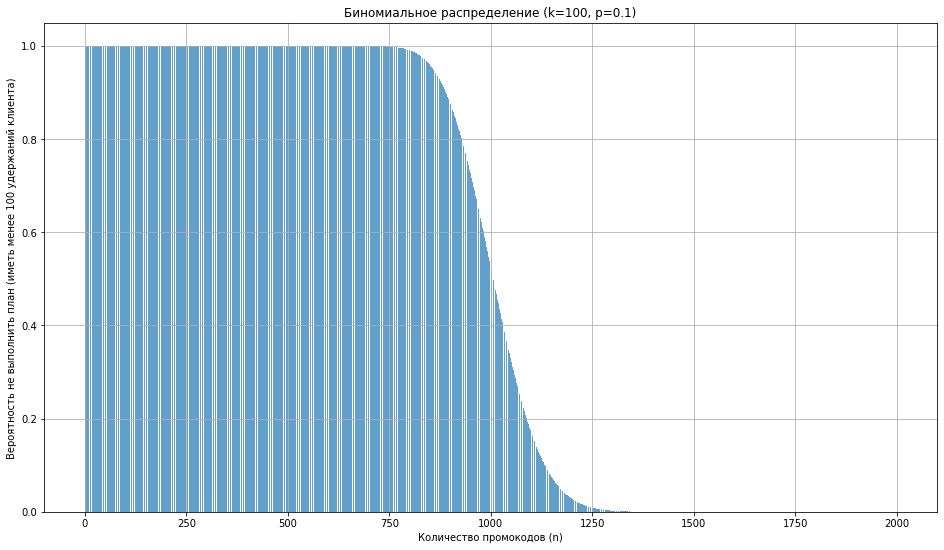

In [24]:
# Параметры биномиального распределения
k = 100  # Количество требуемых успехов
p = 0.1  # Вероятность успеха в каждом испытании

n = np.arange(0, 2000)

cdf = 1-binom.cdf(k, n, p)

plt.figure(figsize=(16, 9))
plt.bar(n, 1 - cdf, align='center', alpha=0.7)
#plt.xticks(k)
plt.xlabel('Количество промокодов (n)')
plt.ylabel('Вероятность не выполнить план (иметь менее 100 удержаний клиента)')
plt.title('Биномиальное распределение (k=100, p=0.1)')
plt.grid(which='both')
plt.show()

График CDF (кумулятивная функция распределения) наглядно подтверждает, что вероятность провала (удержания менее 100 пользователей с подпиской) находится около 1170 выданных промокодов.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Проверка ошибки аппроксимации биномиального распределения открытия push-уведомлений пользователями 

In [25]:
# задаём параметры биномиального распределения
n = 1000 #количество уведомлений для проверки ошибки аппроксимации
p = 0.4 #вероятность успеха (открытия уведомления)

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение с рассчитанными параметрами
distr = st.norm(mu, sigma) 

# найдём суммарную ошибку аппроксимации:
error_values = []
for i in range(n + 1):
    error = abs(st.binom.pmf(i, n, p) - (distr.cdf(i + 0.5) - distr.cdf(i - 0.5)))
    error_values.append(error)
 
print('Средняя разница вероятностей на значение:', sum(error_values) / len(error_values))
print('Максимальная разница вероятностей:', max(error_values))

Средняя разница вероятностей на значение: 3.247073994585863e-06
Максимальная разница вероятностей: 7.827094494087736e-05


Ошибка аппроксимации крайне мала - можно применять аппроксимацию для количества уведомлений более 1000

In [26]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))


# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399.5 тысяч
result = distr.cdf(399500)
print('Вероятность открытия менее 399500 уведомлений при вероятности открытия 40% и 1000000 уведомлении, %:', round(result*100, 2))

Вероятность открытия менее 399500 уведомлений при вероятности открытия 40% и 1000000 уведомлении, %: 15.37


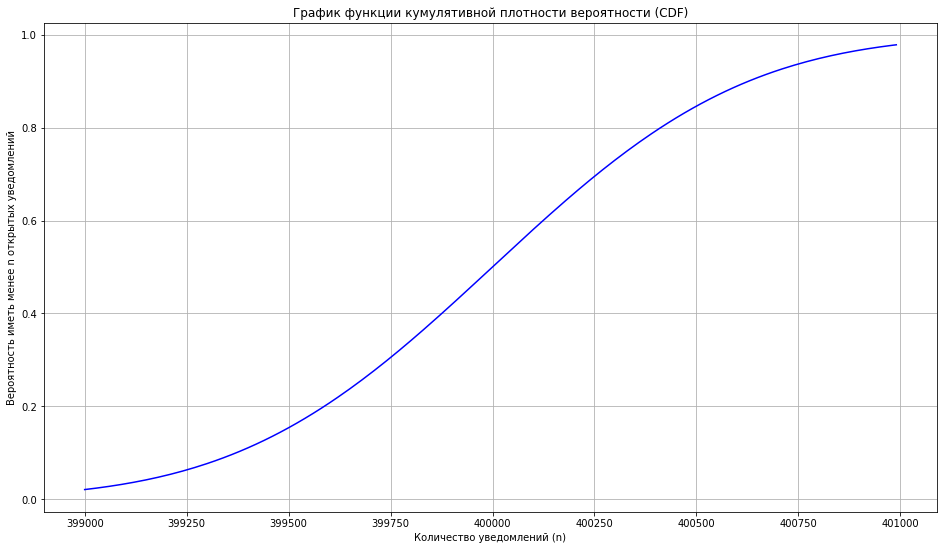

In [27]:
n = np.arange(399000, 401000, 10) # диапазон открытых уведомлений для график
cdf = distr.cdf(n)

plt.figure(figsize=(16, 9))
plt.plot(n, cdf, color='blue')
plt.xlabel('Количество уведомлений (n)')
plt.ylabel('Вероятность иметь менее n открытых уведомлений')
plt.title('График функции кумулятивной плотности вероятности (CDF)')
plt.grid(which='both')
plt.show()

График наглядно демонстрирует рассчитанную выше вероятность